# install

In [1]:
!pip install kagglehub
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=69b53caea2a99866c27115ac8dc8d390c0f72c130fbf8672e34c410d36fcd55c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=2d1f9a195a4c7dffc1a80040d730fc1deac51152c1c05f301251bd7df46ee675
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

# Download Dataset

- https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/kvasir-dataset-for-classification-and-segmentation")

print("Path to dataset files:", path)

100%|██████████| 1.20G/1.20G [00:16<00:00, 78.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation/versions/1


In [3]:
mv /root/.cache/kagglehub/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation/versions/1 .

# Implementation

In [4]:
import os
import cv2
import numpy as np
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

In [6]:
Image_dir = "/content/1/kvasir-seg/Kvasir-SEG/images"
Mask_dir = "/content/1/kvasir-seg/Kvasir-SEG/masks"
batch_size = 64
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [9]:
class SegmentationDataset(Dataset):

    def __init__(self,img_paths:list,mask_paths:list,transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(256,256))
        image = image.astype('float32') / 255.0

        mask = cv2.imread(self.mask_paths[index],cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(256,256))
        mask = mask.astype('float32') / 255.0
        mask = np.expand_dims(mask,axis=0) # (1,256,256)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask)

        return image, mask



image_paths = sorted(glob(os.path.join(Image_dir,"*jpg")))
mask_paths = sorted(glob(os.path.join(Mask_dir,"*jpg")))

train_images,val_images, train_mask, val_mask = train_test_split(image_paths,
                                                                 mask_paths,
                                                                 test_size=0.2,
                                                                 random_state=42
                                                                 )


train_dataset =  SegmentationDataset(train_images,train_mask)
val_dataset =  SegmentationDataset(val_images,val_mask)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)


In [10]:
img,mask = train_dataset[0]

In [12]:
img.size(), mask.size()

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

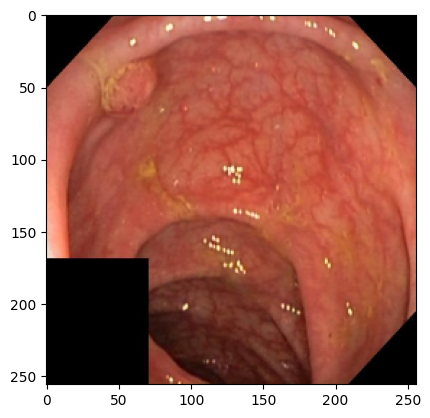

In [13]:
plt.imshow(img.permute(1,2,0))

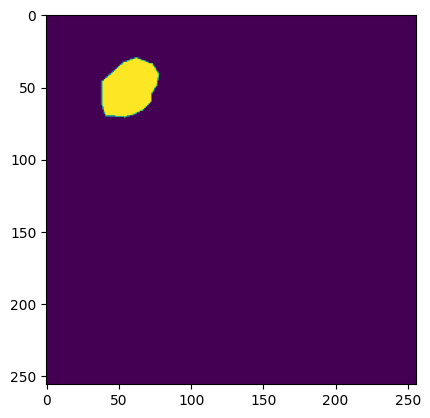

In [15]:
plt.imshow(mask.permute(1,2,0))

## Model

In [18]:
model = smp.Unet(encoder_name='resnet34',encoder_weights='imagenet',in_channels=3,classes=1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 316MB/s]


## Trainig  pipeline

In [20]:
best_loss = float("inf")
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images,mask in train_loader:
        images,mask = images.to(device), mask.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, mask in val_loader:
            images,mask = images.to(device), mask.to(device)
            output = model(images)
            loss = criterion(output,mask)
            val_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)

    print(f"Epoch : {epoch}/{epochs}, Train Loss : {train_loss}, Val Loss : {val_loss}")

    if val_loss < best_loss:
        best_less = val_loss
        torch.save(model.state_dict(),"best_model.pth")
        print(f"saveing best model with val_loss {val_loss} at best_model.pth")

Epoch : 0/10, Train Loss : 0.2920336379454686, Val Loss : 0.5525047481060028
saveing best model with val_loss 0.5525047481060028 at best_model.pth
Epoch : 1/10, Train Loss : 0.208231664620913, Val Loss : 0.3638380840420723
saveing best model with val_loss 0.3638380840420723 at best_model.pth
Epoch : 2/10, Train Loss : 0.15521143949948824, Val Loss : 0.21166330203413963
saveing best model with val_loss 0.21166330203413963 at best_model.pth
Epoch : 3/10, Train Loss : 0.12664088377585778, Val Loss : 0.1792180798947811
saveing best model with val_loss 0.1792180798947811 at best_model.pth
Epoch : 4/10, Train Loss : 0.10311968395343193, Val Loss : 0.2523178942501545
saveing best model with val_loss 0.2523178942501545 at best_model.pth
Epoch : 5/10, Train Loss : 0.10088006177773842, Val Loss : 0.20045602694153786
saveing best model with val_loss 0.20045602694153786 at best_model.pth
Epoch : 6/10, Train Loss : 0.08401816739485814, Val Loss : 0.32146862149238586
saveing best model with val_loss

## Inference

In [21]:
def infer_and_visualize(model,image_path,device):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256))
    image = image.astype('float32') / 255.0 #(256,256,3)

    image_tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0).to(device) # (1,3,256,256)

    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output).cpu().squeeze().numpy()
        output = (output > 0.5).astype(np.uint8)


    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image)


    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(output)

    plt.subplot(1,3,3)
    plt.title("overlap")
    plt.imshow(image)
    plt.imshow(output,cmap='jet',alpha=0.5)


    plt.show()



In [22]:
model.load_state_dict(torch.load("/content/best_model.pth"))

<ipython-input-22-cee503d5b519>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model.pth"))


<All keys matched successfully>

In [23]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

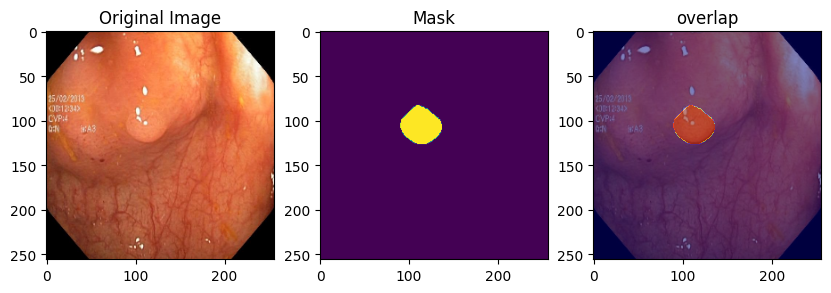

In [26]:
sample_image = "/content/1/kvasir-seg/Kvasir-SEG/images/cju17hw9hr9c5098800fu4u8e.jpg"
infer_and_visualize(model,sample_image,device)